<a href="https://colab.research.google.com/github/nyoons/ESAA/blob/main/%EC%BA%90%EA%B8%80_%ED%95%84%EC%82%AC_%EC%95%99%EC%83%81%EB%B8%94.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Titanic Top 4% with ensemble modeling**
**Titanic - Machine Learning from Disaster 대회**

##1. Introduction

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
from collections import Counter

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve

sns.set(style='white', context='notebook', palette='deep')

##2. Load and check data

###2.1 load data

In [3]:
train=pd.read_csv("train.csv")
test=pd.read_csv("test.csv")
IDtest=test["PassengerId"]

###2.2 Outlier detection

In [4]:
def detect_outliers(df,n,features):
  outlier_indices=[]
    
  #iterate over features(columns)
  for col in features:
    #1st quartile(25%)       
    Q1=np.percentile(df[col], 25)
    #3rd quartile(75%)
    Q3=np.percentile(df[col],75)
    #Interquartile range(IQR)
    IQR=Q3-Q1
        
    #outlier step
    outlier_step=1.5*IQR
        
    #Determine a list of indices of outliers for feature col
    outlier_list_col=df[(df[col]<Q1-outlier_step) | (df[col]>Q3+outlier_step)].index
        
    #append the found outlier indices for col to the list of outlier indices 
    outlier_indices.extend(outlier_list_col)
        
  #select observations containing more than 2 outliers
  outlier_indices=Counter(outlier_indices)        
  multiple_outliers=list(k for k, v in outlier_indices.items() if v>n)
    
  return multiple_outliers   

#detect outliers from Age, SibSp , Parch and Fare
Outliers_to_drop=detect_outliers(train,2,["Age","SibSp","Parch","Fare"])

이상치는 회귀 예측에 큰 영향을 줄 수 있기 때문에 처리가 필요하다.

이렇게 IQR을 사용해 이상치를 탐지하는 방식은 Tukey 방식이라고 함.

위에서 숫자형 변수인 Age, SibSp, Parch, Fare에 대해 이상치를 탐지했다. 각 숫자형 변수들에 대해 총 2개 이상의 이상치가 발견되면 이상치 행이라고 정의했다.

In [5]:
#Show the oultiers rows
train.loc[Outliers_to_drop]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
27,28,0,1,"Fortune, Mr. Charles Alexander",male,19.0,3,2,19950,263.00,C23 C25 C27,S
88,89,1,1,"Fortune, Miss. Mabel Helen",female,23.0,3,2,19950,263.00,C23 C25 C27,S
159,160,0,3,"Sage, Master. Thomas Henry",male,NaN,8,2,CA. 2343,69.55,NaN,S
180,181,0,3,"Sage, Miss. Constance Gladys",female,NaN,8,2,CA. 2343,69.55,NaN,S
201,202,0,3,"Sage, Mr. Frederick",male,NaN,8,2,CA. 2343,69.55,NaN,S
324,325,0,3,"Sage, Mr. George John Jr",male,NaN,8,2,CA. 2343,69.55,NaN,S
341,342,1,1,"Fortune, Miss. Alice Elizabeth",female,24.0,3,2,19950,263.00,C23 C25 C27,S
792,793,0,3,"Sage, Miss. Stella Anna",female,NaN,8,2,CA. 2343,69.55,NaN,S
846,847,0,3,"Sage, Mr. Douglas Bullen",male,NaN,8,2,CA. 2343,69.55,NaN,S
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.55,NaN,S


총 10개의 이상치 행이 발견되었다.

passengerID 28, 89, 342번 승객의 ticket fare가 높다.
다른 7개 행은 SibSp의 값이 매우 높다.

In [6]:
#Drop outliers
train = train.drop(Outliers_to_drop, axis = 0).reset_index(drop=True)

###2.3 joining train and test set

feature engineering을 진행하는 동안 피처 개수를 같게 하기 위해 train과 test 데이터를 합치자.

In [7]:
train_len=len(train)
dataset=pd.concat(objs=[train, test], axis=0).reset_index(drop=True)

###2.4 check for null and missing values

In [8]:
#Fill empty and NaNs values with NaN
dataset=dataset.fillna(np.nan)

#Check for Null values
dataset.isnull().sum()

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             256
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1007
Embarked          2
dtype: int64

Age와 Cabin 피처에 null 값이 많다. 여기서 Survived의 missing value는 test 데이터를 합치는 과정에서 발생한 것이므로 고려하지 않는다.

In [9]:
#Infos
train.info()
train.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 881 entries, 0 to 880
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  881 non-null    int64  
 1   Survived     881 non-null    int64  
 2   Pclass       881 non-null    int64  
 3   Name         881 non-null    object 
 4   Sex          881 non-null    object 
 5   Age          711 non-null    float64
 6   SibSp        881 non-null    int64  
 7   Parch        881 non-null    int64  
 8   Ticket       881 non-null    object 
 9   Fare         881 non-null    float64
 10  Cabin        201 non-null    object 
 11  Embarked     879 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 82.7+ KB


PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            170
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          680
Embarked         2
dtype: int64

In [10]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [11]:
train.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [12]:
###Summarize data
#Summarie and statistics
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,881.000000,881.000000,881.000000,711.000000,881.000000,881.000000,881.000000
mean,446.713961,0.385925,2.307605,29.731603,0.455165,0.363224,31.121566
std,256.617021,0.487090,0.835055,14.547835,0.871571,0.791839,47.996249
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,226.000000,0.000000,2.000000,20.250000,0.000000,0.000000,7.895800
50%,448.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.000000,1.000000,3.000000,38.000000,1.000000,0.000000,30.500000
max,891.000000,1.000000,3.000000,80.000000,5.000000,6.000000,512.329200


##3. Feature analysis

###3.1 Numerical values

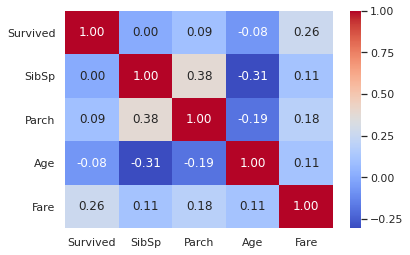

In [13]:
#Correlation matrix between numerical values (SibSp Parch Age and Fare values) and Survived 
g=sns.heatmap(train[["Survived","SibSp","Parch","Age","Fare"]].corr(), annot=True, fmt=".2f", cmap="coolwarm")

다른 변수들은 딱히 상관관계가 없어 보이고 Fare 피처만 Survived 피처와 상관관계가 있어보인다.

다른 피처가 필요 없다는건 아님. 다른 피처의 하위집단은 survived와 관련이 있을 수도 있다.

다른 피처들을 더 자세히 살펴보자.

**SibSP**

In [14]:
pip install seaborn==0.9.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


/usr/local/lib/python3.9/dist-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr/local/lib/python3.9/dist-packages/seaborn/categorical.py:3672: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


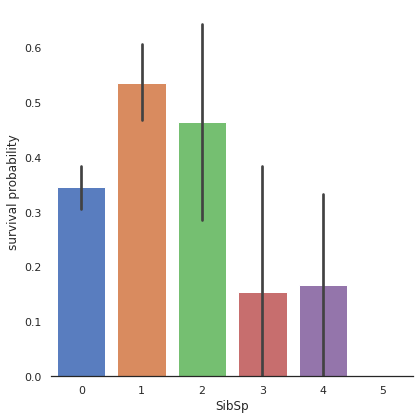

In [15]:
#Explore SibSp feature vs Survived
g=sns.factorplot(x="SibSp", y="Survived", data=train, kind="bar", size=6, palette="muted")
g.despine(left=True)
g=g.set_ylabels("survival probability")

SibSp가 많은 사람일수록 생존확률이 적어보인다. 따라서 이 변수를 설명할 수 있는 새 피처를 고려해 볼 수 있다.

**Parch**

/usr/local/lib/python3.9/dist-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr/local/lib/python3.9/dist-packages/seaborn/categorical.py:3672: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


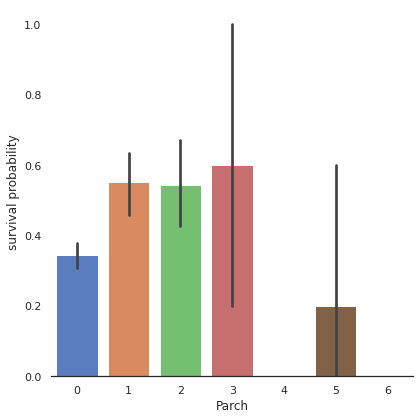

In [16]:
#Explore Parch feature vs Survived
g=sns.factorplot(x="Parch", y="Survived", data=train, kind="bar", size=6, palette="muted")
g.despine(left=True)
g=g.set_ylabels("survival probability")

싱글이나 대가족보단 parch=1,2 정도의 소가족이 생존확률이 높아보인다. 또한 parch=3 경우 큰 표준편차가 보인다.

**Age**

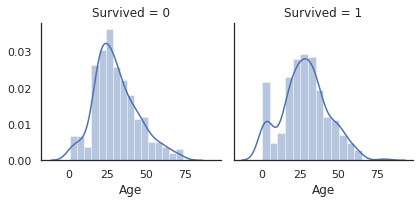

In [17]:
#Explore Age vs Survived
g=sns.FacetGrid(train, col='Survived')
g=g.map(sns.distplot, "Age")

survived 여부에 따라 나이 분포에 차이가 있어 보인다. 생존한 사람 그래프에서는 젊은 나이에서 솟아 올랐고, 60-80대는 덜 생존했다.

따라서 Age와 Survived는 상관관계가 없었지만, 나이 범주에 따라 생존확률이 달라질 것이다.

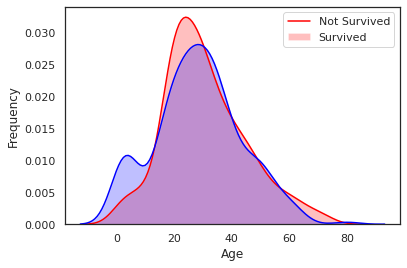

In [18]:
#Explore Age distibution 
g=sns.kdeplot(train["Age"][(train["Survived"]==0) & (train["Age"].notnull())], color="Red", shade=True)
g=sns.kdeplot(train["Age"][(train["Survived"]==1) & (train["Age"].notnull())], ax=g, color="Blue", shade=True)
g.set_xlabel("Age")
g.set_ylabel("Frequency")
g=g.legend(["Not Survived", "Survived"])

겹쳐서 그려보면 확실히 0-5세 아기들이 많이 생존했음을 알 수 있다.

**Fare**

In [19]:
dataset["Fare"].isnull().sum()

1

In [20]:
#Fill Fare missing values with the median value
dataset["Fare"]=dataset["Fare"].fillna(dataset["Fare"].median())

위에서 null 개수를 보았을 때 fare에 결측값이 하나 있었다. 예측에 큰 영향을 주지 않도록 중앙값으로 채워주자.

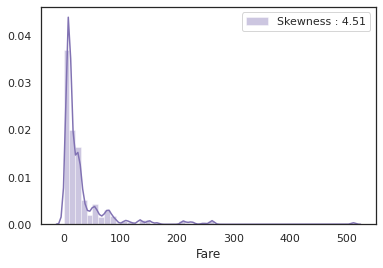

In [21]:
#Explore Fare distribution 
g=sns.distplot(dataset["Fare"], color="m", label="Skewness : %.2f"%(dataset["Fare"].skew()))
g=g.legend(loc="best")

fare 분포는 왜도가 심하다. 이럴 경우 scale을 해도 제대로 예측을 못 할 위험이 있다.

이럴 때는 로그 변환이 낫다.

In [22]:
#Apply log to Fare to reduce skewness distribution
dataset["Fare"]=dataset["Fare"].map(lambda i : np.log(i) if i>0 else 0)

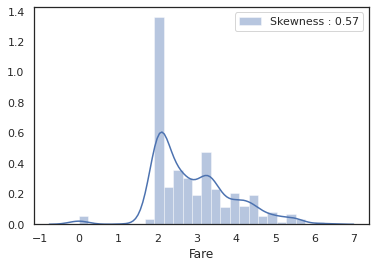

In [23]:
#로그 변환한 그래프를 다시 그려주자
g=sns.distplot(dataset["Fare"], color="b", label="Skewness : %.2f"%(dataset["Fare"].skew()))
g=g.legend(loc="best")

로그변환 후 왜도가 훨씬 감소했다.

###3.2 Categorical values

**Sex**

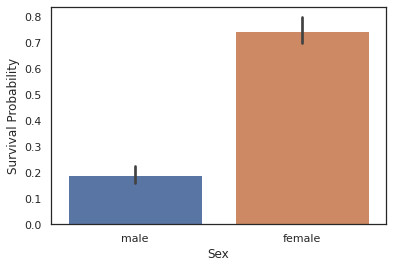

In [24]:
#Explore Sex vs Survived
g=sns.barplot(x='Sex', y='Survived', data=train)
g=g.set_ylabel('Survival Probability')

In [25]:
train[['Sex', 'Survived']].groupby('Sex').mean()

,Survived
Sex,
female,0.747573
male,0.190559


확실히 남자가 여자보다 생존확률이 작다. 성별은 예측에 중요한 변수로 보인다.

**Pclass**

/usr/local/lib/python3.9/dist-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr/local/lib/python3.9/dist-packages/seaborn/categorical.py:3672: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


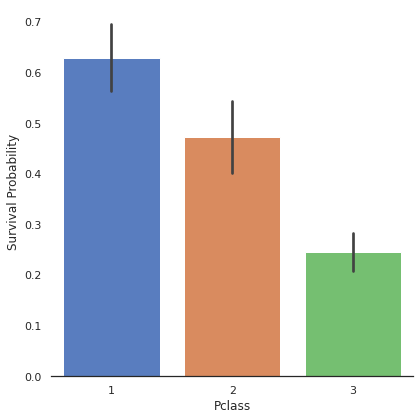

In [26]:
#Explore Pclass vs Survived
g=sns.factorplot(x='Pclass', y='Survived', data=train, kind='bar', size=6, palette='muted')
g.despine(left=True)
g=g.set_ylabels('Survival Probability')

/usr/local/lib/python3.9/dist-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr/local/lib/python3.9/dist-packages/seaborn/categorical.py:3672: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


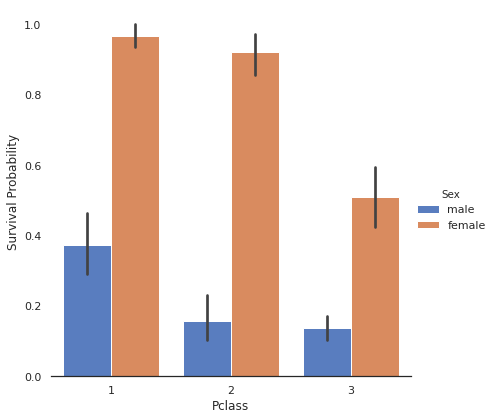

In [29]:
#Explore Pclass vs Survived by Sex
g=sns.factorplot(x='Pclass', y='Survived', hue='Sex', data=train, size=6, kind='bar', palette='muted')
g.despine(left=True)
g=g.set_ylabels('Survival Probability')

1등석 승객들이 3등석 승객들보다 생존확률이 더 높다. 성별로 그룹 지어 봐도 이런 경향이 뚜렷하다.

**Embarked**

In [30]:
dataset['Embarked'].isnull().sum()

2

2개의 null 값이 있었다.

In [31]:
#Fill Embarked nan values of dataset set with 'S' most frequent value
dataset['Embarked']=dataset['Embarked'].fillna('S')

최빈값으로 채워준다.

/usr/local/lib/python3.9/dist-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr/local/lib/python3.9/dist-packages/seaborn/categorical.py:3672: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


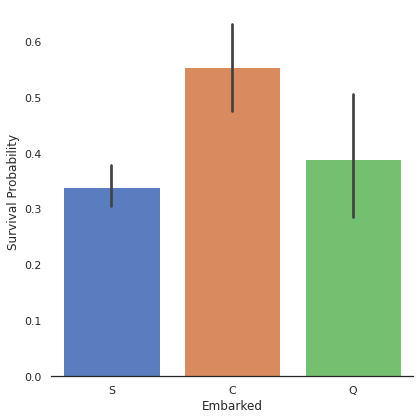

In [32]:
#Explore Embarked vs Survived 
g=sns.factorplot(x='Embarked', y='Survived', data=train, size=6, kind='bar', palette='muted')
g.despine(left=True)
g=g.set_ylabels('Survival Probability')

C(Cherbourg)에서 온 승객들이 생존확률이 높다.

- 가설 : 1등석 승객들 중 Cherbourg에서 온 비율이 높을 것이다.

/usr/local/lib/python3.9/dist-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr/local/lib/python3.9/dist-packages/seaborn/categorical.py:3672: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


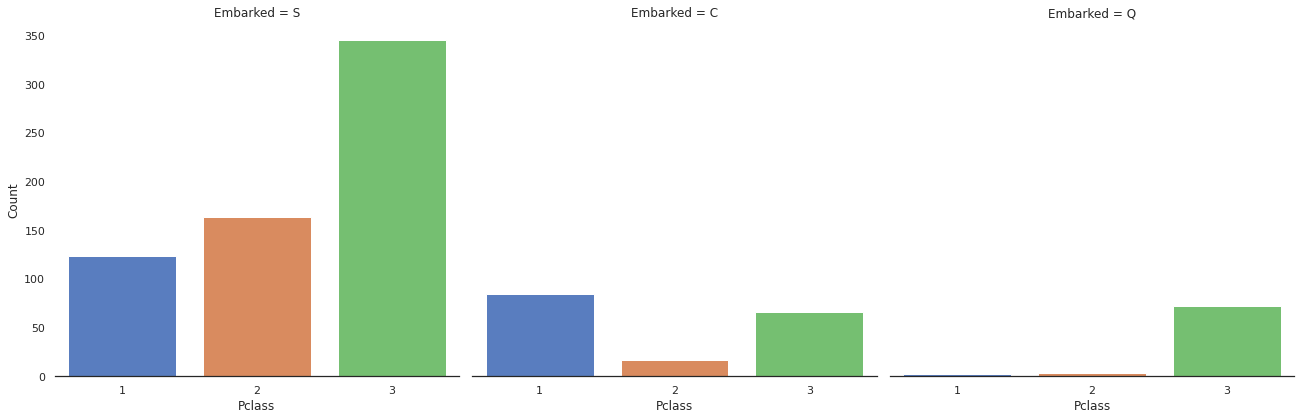

In [33]:
#Explore Pclass vs Embarked 
g=sns.factorplot('Pclass', col='Embarked', data=train, size=6, kind='count', palette='muted')
g.despine(left=True)
g=g.set_ylabels('Count')

Cherbourg에서 온 승객들은 대부분 생존확률이 높았던 1등석에 탔다.

##4. Filling missing Values

###4.1 Age
총 데이터에서 Age 칼럼의 결측치는 256개였다. 특정 연령대는 생존확률이 더 높았던 것처럼 나이는 중요한 변수이니 결측치를 채워서 남겨두는 것이 좋겠다.

어떤 값으로 채우는 것이 좋을지 결정하기 위해 나이와 상관관계가 높아 보이는 피처들을 살펴보자.

/usr/local/lib/python3.9/dist-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr/local/lib/python3.9/dist-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr/local/lib/python3.9/dist-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr

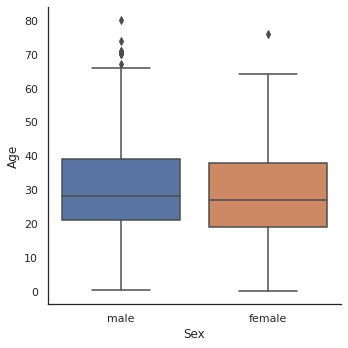

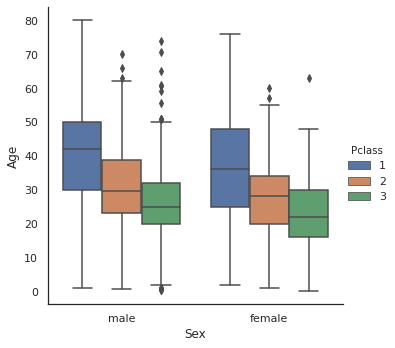

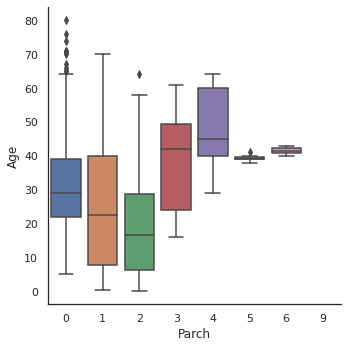

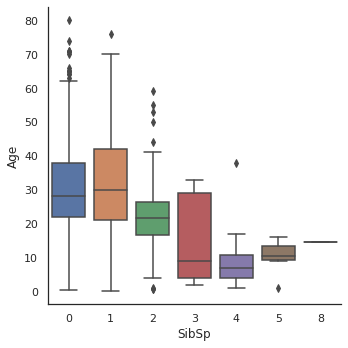

In [34]:
#Explore Age vs Sex, Parch, Pclass and SibSP
g=sns.factorplot(y='Age', x='Sex', data=dataset, kind='box')
g=sns.factorplot(y='Age', x='Sex', hue='Pclass', data=dataset,kind='box')
g=sns.factorplot(y='Age', x='Parch', data=dataset, kind='box')
g=sns.factorplot(y='Age', x='SibSp', data=dataset, kind='box')

- 1등석 승객의 나이 > 2등석 승객의 나이 > 3등석 승객의 나이 의 경향이 있다.
- 또한 부모/자녀의 수가 많을수록 나이가 많고, 형제자매나 배우자가 있을수록 나이가 적었다.



In [35]:
#convert Sex into categorical value 0=male and 1=female
dataset['Sex']=dataset['Sex'].map({'male':0, 'female':1})

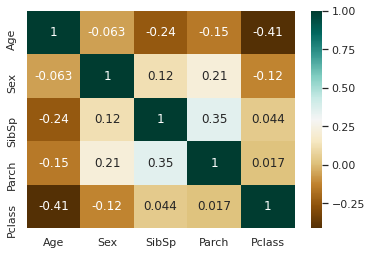

In [36]:
g=sns.heatmap(dataset[['Age', 'Sex', 'SibSp', 'Parch', 'Pclass']].corr(), cmap='BrBG', annot=True)

Age 피처를 보면 확실히 성별과는 별로 관계가 없지만, Pclass, Parch, SibSp와는 음의 상관관계가 보인다.

이 세 가지 변수를 사용해 age의 결측치를 채워주자. Pclass, Parch, SibSp가 비슷한 승객들의 age 중앙값으로 채워줄 것이다.

In [37]:
#Fill Age with the median age of similar rows according to Pclass, Parch and SibSp
#Index of NaN age rows
index_NaN_age=list(dataset['Age'][dataset['Age'].isnull()].index)

for i in index_NaN_age:
  age_med=dataset['Age'].median()
  age_pred=dataset['Age'][((dataset['SibSp']==dataset.iloc[i]['SibSp']) & (dataset['Parch']==dataset.iloc[i]['Parch']) & (dataset['Pclass']==dataset.iloc[i]['Pclass']))].median()
  if not np.isnan(age_pred):
    dataset['Age'].iloc[i]=age_pred
  else:
    dataset['Age'].iloc[i]=age_med

<ipython-input-37-6b53e1aea025>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['Age'].iloc[i]=age_pred
<ipython-input-37-6b53e1aea025>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['Age'].iloc[i]=age_pred
<ipython-input-37-6b53e1aea025>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['Age'].iloc[i]=age_pred
<ipython-input-37-6b53e1aea025>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of

/usr/local/lib/python3.9/dist-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr/local/lib/python3.9/dist-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


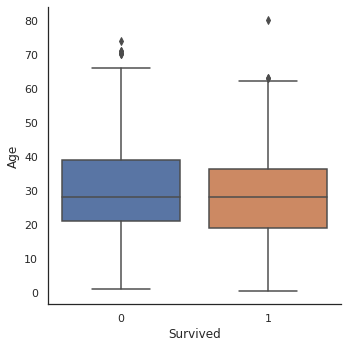

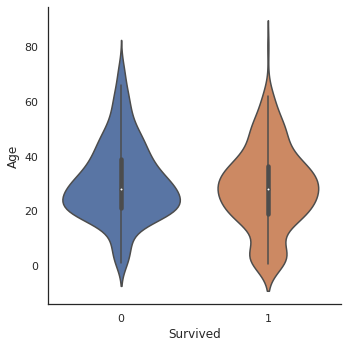

In [38]:
g=sns.factorplot(x='Survived', y='Age', data=train, kind='box')
g=sns.factorplot(x='Survived', y='Age', data=train, kind='violin')

- 상자그림을 보면 생존여부에 따른 나이의 중앙값이 차이가 없다.
- 바이올린 그래프를 보면 어린 승객들이 생존할 확률이 높다.

##5. Feature engineering

###5.1 Name/Title

In [39]:
dataset['Name'].head()

0                              Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                               Heikkinen, Miss. Laina
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                             Allen, Mr. William Henry
Name: Name, dtype: object

특정 타이틀을 가진 승객들이 대피에 유리했을 수도 있으므로 모델에 넣어보도록 하자.

In [40]:
#Get Title from Name
dataset_title=[i.split(',')[1].split('.')[0].strip() for i in dataset['Name']]
dataset['Title']=pd.Series(dataset_title)
dataset['Title'].head()

0      Mr
1     Mrs
2    Miss
3     Mrs
4      Mr
Name: Title, dtype: object

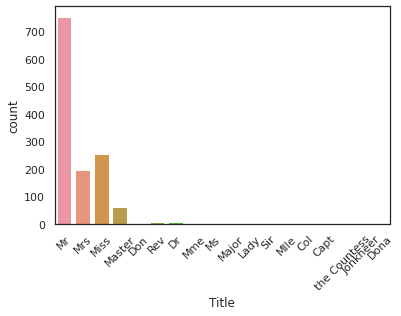

In [41]:
g=sns.countplot(x='Title', data=dataset)
g=plt.setp(g.get_xticklabels(), rotation=45) 

17개의 타이틀이 있다. 수가 너무 적은 타이틀은 다른 타이틀로 그룹화해서 4개 그룹으로 만들자.

In [42]:
#Convert to categorical values Title 
dataset['Title']=dataset['Title'].replace(['Lady','the Countess','Countess','Capt','Col','Don','Dr','Major','Rev','Sir','Jonkheer','Dona'], 'Rare')
dataset['Title']=dataset['Title'].map({"Master":0, "Miss":1, "Ms":1 , "Mme":1, "Mlle":1, "Mrs":1, "Mr":2, "Rare":3})
dataset['Title']=dataset['Title'].astype(int)

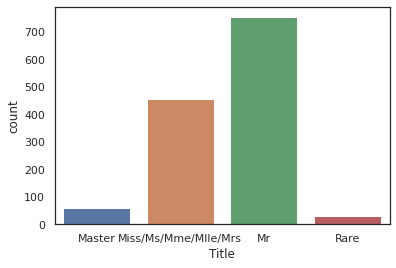

In [43]:
#카운트 plot
g=sns.countplot(dataset['Title'])
g=g.set_xticklabels(['Master', 'Miss/Ms/Mme/Mlle/Mrs', 'Mr', 'Rare'])

/usr/local/lib/python3.9/dist-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


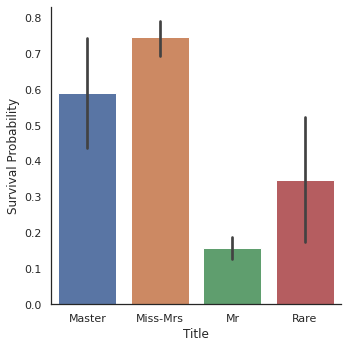

In [44]:
#생존확률 plot
g=sns.factorplot(x='Title', y='Survived', data=dataset, kind='bar')
g=g.set_xticklabels(['Master', 'Miss-Mrs', 'Mr', 'Rare'])
g=g.set_ylabels('Survival Probability')

여자와 특이한 타이틀을 가진 사람들의 생존확률이 높다.

In [45]:
#Drop Name variable
dataset.drop(labels=['Name'], axis=1, inplace=True)

###5.2 Family Size
대가족은 대피가 늦어질 가능성이 높다는 아이디어 -> SibSp+Parch+1 해서 새로운 변수 Fsize를 만들자 (가족 수) 

In [46]:
#Create a family size descriptor from SibSp and Parch
dataset['Fsize']=dataset['SibSp']+dataset['Parch']+1

/usr/local/lib/python3.9/dist-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


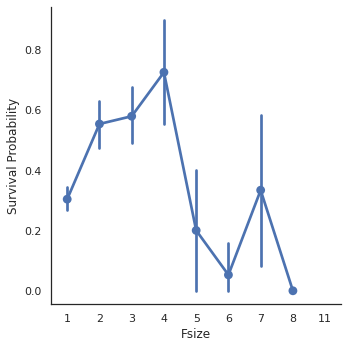

In [47]:
g=sns.factorplot(x='Fsize', y='Survived', data=dataset)
g=g.set_ylabels('Survival Probability')

가족 수는 생존확률에 중요한 영향을 주는 것 같다.

가족 수에 따라 4가지 그룹으로 나누자.

In [48]:
#Create new feature of family size
dataset['Single']=dataset['Fsize'].map(lambda s : 1 if s==1 else 0)
dataset['SmallF']=dataset['Fsize'].map(lambda s : 1 if  s==2  else 0)
dataset['MedF']=dataset['Fsize'].map(lambda s : 1 if 3<= s<= 4 else 0)
dataset['LargeF']=dataset['Fsize'].map(lambda s : 1 if s>=5 else 0)

/usr/local/lib/python3.9/dist-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr/local/lib/python3.9/dist-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr/local/lib/python3.9/dist-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr

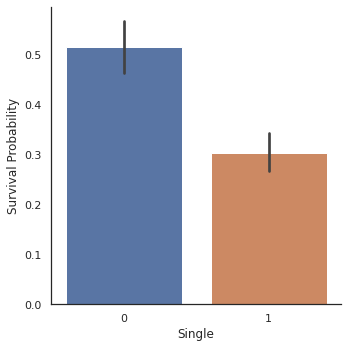

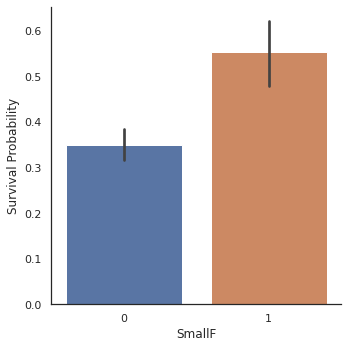

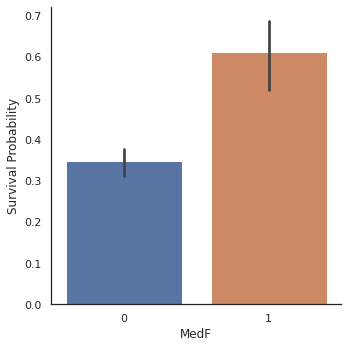

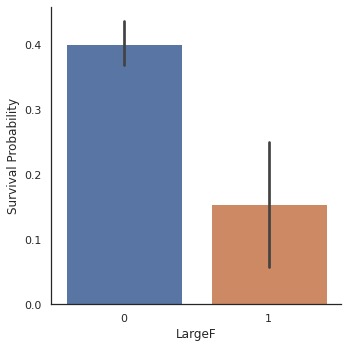

In [49]:
g=sns.factorplot(x='Single', y='Survived', data=dataset, kind='bar')
g=g.set_ylabels('Survival Probability')

g=sns.factorplot(x='SmallF', y='Survived', data=dataset, kind='bar')
g=g.set_ylabels('Survival Probability')

g=sns.factorplot(x='MedF', y='Survived', data=dataset, kind='bar')
g=g.set_ylabels('Survival Probability')

g=sns.factorplot(x='LargeF', y='Survived', data=dataset, kind='bar')
g=g.set_ylabels('Survival Probability')

가족 인원이 5명 이상인 대가족보다 그보다 인원이 적은 가족이 생존확률이 높다.

In [50]:
#Convert to indicator values Title and Embarked 
dataset=pd.get_dummies(dataset, columns=["Title"])
dataset=pd.get_dummies(dataset, columns=["Embarked"], prefix="Em")

In [51]:
dataset.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,...,SmallF,MedF,LargeF,Title_0,Title_1,Title_2,Title_3,Em_C,Em_Q,Em_S
0,1,0.0,3,0,22.0,1,0,A/5 21171,1.981001,NaN,...,1,0,0,0,0,1,0,0,0,1
1,2,1.0,1,1,38.0,1,0,PC 17599,4.266662,C85,...,1,0,0,0,1,0,0,1,0,0
2,3,1.0,3,1,26.0,0,0,STON/O2. 3101282,2.070022,NaN,...,0,0,0,0,1,0,0,0,0,1
3,4,1.0,1,1,35.0,1,0,113803,3.972177,C123,...,1,0,0,0,1,0,0,0,0,1
4,5,0.0,3,0,35.0,0,0,373450,2.085672,NaN,...,0,0,0,0,0,1,0,0,0,1


22개 피처.

###5.3 Cabin

In [52]:
dataset['Cabin'].head()

0     NaN
1     C85
2     NaN
3    C123
4     NaN
Name: Cabin, dtype: object

In [53]:
dataset['Cabin'].describe()

count     292
unique    186
top        G6
freq        5
Name: Cabin, dtype: object

In [54]:
dataset['Cabin'].isnull().sum()

1007

292개의 값과 1007개의 결측치. 결측치는 아마도 cabin 없이 탑승한 승객들.

In [55]:
dataset['Cabin'][dataset['Cabin'].notnull()].head()

1      C85
3     C123
6      E46
10      G6
11    C103
Name: Cabin, dtype: object

In [56]:
#Replace the Cabin number by the type of cabin 'X' if not
dataset['Cabin']=pd.Series([i[0] if not pd.isnull(i) else 'X' for i in dataset['Cabin']])

cabin 넘버의 첫글자는 desk를 뜻함. 이 문자만 떼어서 보관하자.

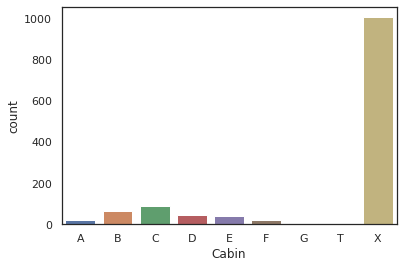

In [57]:
g=sns.countplot(dataset['Cabin'], order=['A','B','C','D','E','F','G','T','X'])

/usr/local/lib/python3.9/dist-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


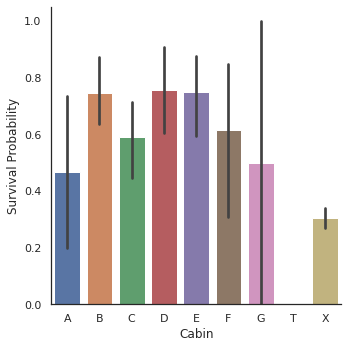

In [58]:
g=sns.factorplot(x='Cabin', y='Survived', data=dataset, kind='bar', order=['A','B','C','D','E','F','G','T','X'])
g=g.set_ylabels('Survival Probability')

애초에 cabin이 있는 승객이 워낙 적다 -> desk별로 생존확률 비교가 어려움. 그러나 확실히 cabin이 없는 승객들보단 cabin이 있는 승객들의 생존확률이 높았다.

In [59]:
dataset=pd.get_dummies(dataset, columns=['Cabin'], prefix='Cabin')

###5.4 Ticket

In [60]:
dataset['Ticket'].head()

0           A/5 21171
1            PC 17599
2    STON/O2. 3101282
3              113803
4              373450
Name: Ticket, dtype: object

앞글자가 같은 티켓은 같은 선실을 예약한 티켓이다. 이런 티켓들끼리는 비슷한 class와 생존확률을 갖게 된다. -> ticket 피처를 ticket prefix 피처로 변경하자.

In [61]:
#Treat Ticket by extracting the ticket prefix. When there is no prefix it returns X. 
Ticket = []

for i in list(dataset.Ticket):
  if not i.isdigit():
    Ticket.append(i.replace('.', '').replace('/', '').strip().split(' ')[0]) #Take prefix
  else:
    Ticket.append('X')
        
dataset['Ticket']=Ticket
dataset['Ticket'].head()

0        A5
1        PC
2    STONO2
3         X
4         X
Name: Ticket, dtype: object

In [62]:
dataset=pd.get_dummies(dataset, columns=['Ticket'], prefix='T')

In [63]:
#Create categorical values for Pclass
dataset['Pclass']=dataset['Pclass'].astype('category')
dataset=pd.get_dummies(dataset, columns=['Pclass'], prefix='Pc')

In [64]:
#Drop useless variables 
dataset.drop(labels=['PassengerId'], axis=1, inplace=True)

In [65]:
dataset.head()

,Survived,Sex,Age,SibSp,Parch,Fare,Fsize,Single,SmallF,MedF,...,T_STONO,T_STONO2,T_STONOQ,T_SWPP,T_WC,T_WEP,T_X,Pc_1,Pc_2,Pc_3
0,0.0,0,22.0,1,0,1.981001,2,0,1,0,...,0,0,0,0,0,0,0,0,0,1
1,1.0,1,38.0,1,0,4.266662,2,0,1,0,...,0,0,0,0,0,0,0,1,0,0
2,1.0,1,26.0,0,0,2.070022,1,1,0,0,...,0,1,0,0,0,0,0,0,0,1
3,1.0,1,35.0,1,0,3.972177,2,0,1,0,...,0,0,0,0,0,0,1,1,0,0
4,0.0,0,35.0,0,0,2.085672,1,1,0,0,...,0,0,0,0,0,0,1,0,0,1


##6. Modeling

In [66]:
#Separate train dataset and test dataset
train=dataset[:train_len]
test=dataset[train_len:]
test.drop(labels=['Survived'], axis=1, inplace=True)

<ipython-input-66-fc3e959b98a7>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.drop(labels=['Survived'], axis=1, inplace=True)


In [67]:
#Separate train features and label 
train['Survived']=train['Survived'].astype(int)
Y_train=train['Survived']
X_train=train.drop(labels=['Survived'], axis=1)

<ipython-input-67-cbf365825a3e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['Survived']=train['Survived'].astype(int)


###6.1 Simple modeling

####6.1.1 Cross validate models
stratified kfold cross validation을 이용해 10개 분류 알고리즘의 평균 accuracy를 비교하자.

In [68]:
#Cross validate model with Kfold stratified cross val
kfold=StratifiedKFold(n_splits=10)

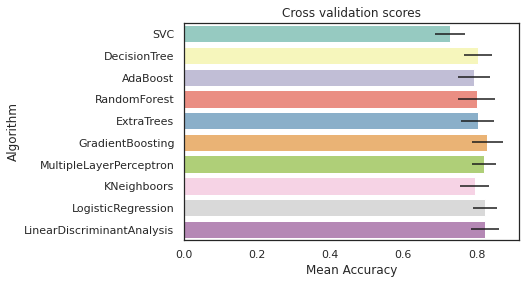

In [69]:
# Modeling step Test differents algorithms 
random_state=2
classifiers=[]
classifiers.append(SVC(random_state=random_state))
classifiers.append(DecisionTreeClassifier(random_state=random_state))
classifiers.append(AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state),random_state=random_state,learning_rate=0.1))
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(ExtraTreesClassifier(random_state=random_state))
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(MLPClassifier(random_state=random_state))
classifiers.append(KNeighborsClassifier())
classifiers.append(LogisticRegression(random_state=random_state))
classifiers.append(LinearDiscriminantAnalysis())

cv_results=[]
for classifier in classifiers:
  cv_results.append(cross_val_score(classifier, X_train, Y_train, scoring='accuracy', cv=kfold, n_jobs=4))

cv_means=[]
cv_std=[]
for cv_result in cv_results:
  cv_means.append(cv_result.mean())
  cv_std.append(cv_result.std())

cv_res=pd.DataFrame({'CrossValMeans' : cv_means,
                     'CrossValerrors' : cv_std,
                     'Algorithm' : ['SVC','DecisionTree','AdaBoost','RandomForest','ExtraTrees','GradientBoosting','MultipleLayerPerceptron','KNeighboors','LogisticRegression','LinearDiscriminantAnalysis']})

g=sns.barplot('CrossValMeans', 'Algorithm', data=cv_res, palette='Set3', orient='h', **{'xerr':cv_std})
g.set_xlabel('Mean Accuracy')
g=g.set_title('Cross validation scores')

성능이 좋아보이는 SVC, AdaBoost, RF, ExtraTrees, GB 분류기를 이용해 앙상블하자.

####6.1.2 하이퍼 파라미터 튜닝 for best models
하이퍼 파라미터 튜닝을 위해 grid search 최적화를 진행하자.

In [70]:
#Meta Modeling w/ Adaboost, RF, ExtraTrees and GB

#Adaboost
DTC=DecisionTreeClassifier()
adaDTC=AdaBoostClassifier(DTC, random_state=7)
ada_param_grid={'base_estimator__criterion' : ['gini', 'entropy'],          
                'base_estimator__splitter' : ['best', 'random'],
                'algorithm' : ['SAMME', 'SAMME.R'],
                'n_estimators' : [1, 2],
                'learning_rate' : [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3, 1.5]}
gsadaDTC=GridSearchCV(adaDTC, param_grid=ada_param_grid, cv=kfold, scoring='accuracy', n_jobs=4, verbose=1)
gsadaDTC.fit(X_train, Y_train)
ada_best=gsadaDTC.best_estimator_

Fitting 10 folds for each of 112 candidates, totalling 1120 fits


/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_search.py:905: FutureWarning: Parameter 'base_estimator' of AdaBoostClassifier is deprecated in favor of 'estimator'. See AdaBoostClassifier's docstring for more details.
  clone(base_estimator).set_params(**self.best_params_)


In [71]:
gsadaDTC.best_score_

0.8275536261491316

In [72]:
#ExtraTrees 
ExtC=ExtraTreesClassifier()

#Search grid for optimal parameters
ex_param_grid={'max_depth' : [None],
               'max_features' : [1, 3, 10],
               'min_samples_split' : [2, 3, 10],
               'min_samples_leaf' : [1, 3, 10],
               'bootstrap' : [False],
               'n_estimators' : [100, 300],
               'criterion' : ['gini']}
gsExtC=GridSearchCV(ExtC, param_grid=ex_param_grid, cv=kfold, scoring='accuracy', n_jobs=4, verbose=1)
gsExtC.fit(X_train, Y_train)
ExtC_best=gsExtC.best_estimator_

gsExtC.best_score_

Fitting 10 folds for each of 54 candidates, totalling 540 fits


0.8308605720122575

In [74]:
# RF
RFC=RandomForestClassifier()

#Search grid for optimal parameters
rf_param_grid={'max_depth' : [None],
               'max_features' : [1, 3, 10],
               'min_samples_split' : [2, 3, 10],
               'min_samples_leaf' : [1, 3, 10],
               'bootstrap' : [False],
               'n_estimators' : [100, 300],
               'criterion' : ['gini']}
gsRFC=GridSearchCV(RFC, param_grid=rf_param_grid, cv=kfold, scoring='accuracy', n_jobs=4, verbose=1)
gsRFC.fit(X_train, Y_train)
RFC_best=gsRFC.best_estimator_

gsRFC.best_score_

Fitting 10 folds for each of 54 candidates, totalling 540 fits


0.833158835546476

In [ ]:
#GB
GBC=GradientBoostingClassifier()
gb_param_grid={'loss' : ['deviance'],
               'n_estimators' : [100, 200, 300],
               'learning_rate' : [0.1, 0.05, 0.01],
               'max_depth' : [4, 8],
               'min_samples_leaf' : [100, 150],
               'max_features' : [0.3, 0.1]}
gsGBC=GridSearchCV(GBC, param_grid=gb_param_grid, cv=kfold, scoring='accuracy', n_jobs=4, verbose=1)
gsGBC.fit(X_train, Y_train)
GBC_best=gsGBC.best_estimator_

gsGBC.best_score_

In [ ]:
#SVC
SVMC=SVC(probability=True)
svc_param_grid={'kernel' : ['rbf'], 
                'gamma' : [0.001, 0.01, 0.1, 1],
                'C' : [1, 10, 50, 100, 200, 300, 1000]}
gsSVMC=GridSearchCV(SVMC, param_grid=svc_param_grid, cv=kfold, scoring='accuracy', n_jobs=4, verbose=1)
gsSVMC.fit(X_train, Y_train)
SVMC_best=gsSVMC.best_estimator_

gsSVMC.best_score_

####6.1.3 Plot learning curves
과대적합 영향을 볼 수 있다.

In [ ]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 5)):
    """Generate a simple plot of the test and training learning curve"""
    plt.figure()
    plt.title(title)
    if ylim is not None:
      plt.ylim(*ylim)
    plt.xlabel('Training examples')
    plt.ylabel('Score')
    train_sizes, train_scores, test_scores=learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean=np.mean(train_scores, axis=1)
    train_scores_std=np.std(train_scores, axis=1)
    test_scores_mean=np.mean(test_scores, axis=1)
    test_scores_std=np.std(test_scores, axis=1)
    plt.grid()
    plt.fill_between(train_sizes, train_scores_mean-train_scores_std, train_scores_mean+train_scores_std, alpha=0.1, color='r')
    plt.fill_between(train_sizes, test_scores_mean-test_scores_std, test_scores_mean+test_scores_std, alpha=0.1, color='g')
    plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Training score')
    plt.plot(train_sizes, test_scores_mean, 'o-', color='g', label='Cross-validation score')
    plt.legend(loc='best')
    return plt

g=plot_learning_curve(gsRFC.best_estimator_, 'RF mearning curves', X_train, Y_train, cv=kfold)
g=plot_learning_curve(gsExtC.best_estimator_, 'ExtraTrees learning curves', X_train, Y_train, cv=kfold)
g=plot_learning_curve(gsSVMC.best_estimator_, 'SVC learning curves', X_train, Y_train, cv=kfold)
g=plot_learning_curve(gsadaDTC.best_estimator_, 'AdaBoost learning curves', X_train, Y_train, cv=kfold)
g=plot_learning_curve(gsGBC.best_estimator_, 'GradientBoosting learning curves', X_train, Y_train, cv=kfold)

GB와 Ada 분류가 train 세트에 대해 과대적합 되었다. train 세트가 조금 더 컸다면 이보다 더 좋은 성능이 나왔을 것이다.

SVC와 ET의 train 커브, cross-validation 커브가 비슷하므로 이 두 분류가 더 적합하다.

####6.1.4 Feature Importance of the tree based classifiers
feature_importances_를 이용해 분석에 중요한 변수들을 보자.

In [ ]:
nrows=ncols=2
fig, axes=plt.subplots(nrows=nrows, ncols=ncols, sharex='all', figsize=(15,15))
names_classifiers=[('AdaBoosting', ada_best),('ExtraTrees', ExtC_best),('RandomForest', RFC_best), ('GradientBoosting', GBC_best)]
nclassifier=0
for row in range(nrows):
    for col in range(ncols):
      name=names_classifiers[nclassifier][0]
      classifier=names_classifiers[nclassifier][1]
      indices=np.argsort(classifier.feature_importances_)[::-1][:40]
      g=sns.barplot(y=X_train.columns[indices][:40], x=classifier.feature_importances_[indices][:40], orient='h', ax=axes[row][col])
      g.set_xlabel('Relative importance', fontsize=12)
      g.set_ylabel('Features', fontsize=12)
      g.tick_params(labelsize=9)
      g.set_title(name+'feature importance')
      nclassifier+=1

서로 완전히 같은 피처를 이용해 예측 하지 않는다. 하지만 공통적으로 fare, title_2, sex 피처는 중요해 보인다.

승객의 사회적 지위, 성별, 나이, 가족 수 관련된 피처가 분석 결과와 높은 관련을 보인다.

In [ ]:
test_Survived_RFC=pd.Series(RFC_best.predict(test), name='RFC')
test_Survived_ExtC=pd.Series(ExtC_best.predict(test), name='ExtC')
test_Survived_SVMC=pd.Series(SVMC_best.predict(test), name='SVC')
test_Survived_AdaC=pd.Series(ada_best.predict(test), name='Ada')
test_Survived_GBC=pd.Series(GBC_best.predict(test), name='GBC')

#Concatenate all classifier results
ensemble_results=pd.concat([test_Survived_RFC, test_Survived_ExtC, test_Survived_AdaC, test_Survived_GBC, test_Survived_SVMC], axis=1)

g=sns.heatmap(ensemble_results.corr(), annot=True)

Ada를 제외한 나머지 분류끼리는 예측이 비슷해보인다. 분류끼리의 약간의 차이는 앙상블을 하기에 충분해 보인다.

###6.2 Ensemble modeling

####6.2.1 Combining models
소프트 보팅을 통해 보팅 분류기로 모델들을 합치자.

In [ ]:
votingC=VotingClassifier(estimators=[('rfc', RFC_best), ('extc', ExtC_best), ('svc', SVMC_best), ('adac',ada_best),('gbc',GBC_best)], voting='soft', n_jobs=4)
votingC=votingC.fit(X_train, Y_train)

###6.3 Prediction

####6.3.1 Predict and Submit results

In [ ]:
test_Survived=pd.Series(votingC.predict(test), name='Survived')
results=pd.concat([IDtest, test_Survived], axis=1)
results.to_csv('ensemble_python_voting.csv', index=False)